<a href="https://colab.research.google.com/github/mathgurgel/TP_IA/blob/main/tp_ia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algoritmos de Classificação

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, f1_score

import pandas as pd

In [62]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

### Google drive imports

In [63]:
# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

### Download files from drive

In [64]:
def download_file(id, path):

  download = drive.CreateFile({'id': id})
  download.GetContentFile(path)

In [65]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

download_file('1jVJ6-E_iprDUT7RCVYQUihimiMIZq_x-', 'falencia-treinamento.csv')
download_file('1gn4Cvh8xgPGwC1lhxSpyej6Tykh-MQrn', 'falencia-teste.csv')
download_file('135HD0_Shn4OnHntGrd0LuZCMZST8001J', 'modelo-submissao.csv')

## Leitura dos dados

In [66]:
#Lendo os dados
df_training = pd.read_csv('falencia-treinamento.csv')
df_test = pd.read_csv('falencia-teste.csv')
df_test_result = pd.read_csv('modelo-submissao.csv')

#Melhorando o resultado aumentando o tamanho dos dados de treinamento
df_training_copy = df_training.copy()
df_training_copy = df_training_copy.sample(frac=1).reset_index(drop=True)
df = pd.concat([df_training, df_training_copy], ignore_index=True, sort=False)

#Aumentando base de dados utilizando a técnica SMOTE para aumentar a classe minoritária
X = df.drop('Resultado', axis='columns')
y = df['Resultado']

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
df_res = pd.concat([X_res, y_res], axis=1)

## Pre processing

In [67]:
X_res = df_res.drop('Resultado', axis='columns')
y_res = df_res['Resultado']

#Nova divisão treino e teste para tentar melhorar os resultados
#kf = KFold(n_splits=5, shuffle=True, random_state=10)
kf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)
#kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#kf =RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=10)
for train_index, test_index in kf.split(df_res):
    # Split data into train and test sets
    X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
    y_train, y_test = y_res.iloc[train_index], y_res.iloc[test_index]

## Logistic Regression

In [60]:
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

def logistic_regression():

    # Generate a random classification dataset
    X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Cria o modelo de regressão logística
    logistic_regression = LogisticRegression(C=0.01, random_state=42, max_iter=1000)

    # Create a Bagging Classifier model
    bagging_logreg = BaggingClassifier(estimator=logistic_regression, n_estimators=10, random_state=42)

    # Train the Bagging Classifier model
    bagging_logreg.fit(X_train, y_train)

    # Predict the test set
    y_pred = bagging_logreg.predict(X_test)

    # Evaluate the performance of the model
    accuracy = accuracy_score(y_test, y_pred)
    f_measure = f1_score(y_test, y_pred)
    
    print('Logistic Regression')
    print('Acurácia: ', accuracy)
    print('F-Measure: ', f_measure)

    y_pred = y_pred.flatten()
    fper, tper, thresholds = roc_curve(y_test, y_pred)
    plot_roc_curve(fper, tper)


## Decision Tree

In [68]:
def decision_tree():
    # Separa as variáveis independentes e dependentes (treinamento)
    #independent_variables_training = df_training.drop('Resultado', axis='columns')
    #dependent_variable_training = df_training['Resultado']

    # Recebe as variáveis independentes do conjunto de teste
    #independent_variables_test = df_test

    independent_variables_training = X_train
    dependent_variable_training = y_train

    independent_variables_test = X_test 

    # Cria o modelo de Decision Tree
    decision_tree = DecisionTreeClassifier(random_state=10)

    # Treina o modelo
    decision_tree.fit(independent_variables_training, dependent_variable_training)

    # Faz a previsão do modelo
    prediction = decision_tree.predict(independent_variables_test) # Resultado do modelo

    # Calcula a acurácia do modelo
    #accuracy = accuracy_score(df_test_result['Resultado'], prediction)
    #f_measure = f1_score(df_test_result['Resultado'], prediction)
    
    accuracy = accuracy_score(y_test, prediction)
    f_measure = f1_score(y_test, prediction)

    print('Decision Tree')
    print('Acurácia: ', accuracy)
    print('F-Measure: ', f_measure)

    prediction = prediction.flatten()
    fper, tper, thresholds = roc_curve(y_test, prediction)
    plot_roc_curve(fper, tper)

## Random Forest

In [69]:
def random_forest():
    # Separa as variáveis independentes e dependentes (treinamento)
    #independent_variables_training = df_training.drop('Resultado', axis='columns')
    #dependent_variable_training = df_training['Resultado']

    # Recebe as variáveis independentes do conjunto de teste
    #independent_variables_test = df_test

    independent_variables_training = X_train
    dependent_variable_training = y_train

    independent_variables_test = X_test

    # Cria o modelo de Random Forest
    random_forest = RandomForestClassifier(random_state=10)

    # Treina o modelo
    random_forest.fit(independent_variables_training, dependent_variable_training)

    # Faz a previsão do modelo
    prediction = random_forest.predict(independent_variables_test) # Resultado do modelo

    # Calcula a acurácia do modelo
    #accuracy = accuracy_score(df_test_result['Resultado'], prediction)
    #f_measure = f1_score(df_test_result['Resultado'], prediction)
    
    accuracy = accuracy_score(y_test, prediction)
    f_measure = f1_score(y_test, prediction)

    print('Random Forest')
    print('Acurácia: ', accuracy)
    print('F-Measure: ', f_measure)

    prediction = prediction.flatten()
    fper, tper, thresholds = roc_curve(y_test, prediction)
    plot_roc_curve(fper, tper)

## Resultados

Logistic Regression
Acurácia:  0.825
F-Measure:  0.8325358851674641


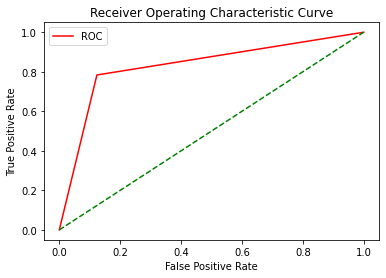

Decision Tree
Acurácia:  0.9727272727272728
F-Measure:  0.9739130434782608


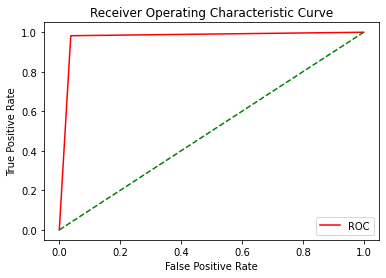

Random Forest
Acurácia:  0.990909090909091
F-Measure:  0.9911504424778761


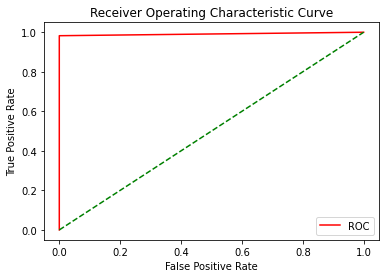

In [70]:
logistic_regression()
decision_tree()
random_forest()